(2072, 2072, 4)


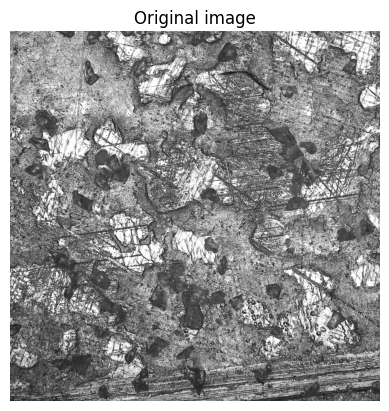

(2072, 2072)


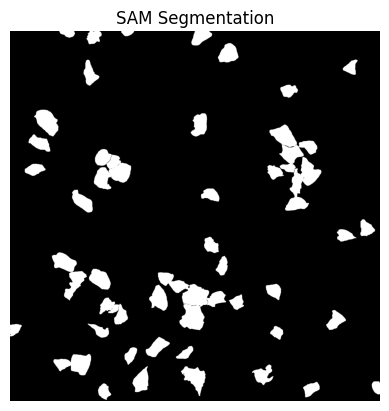

(2072, 2072, 4)


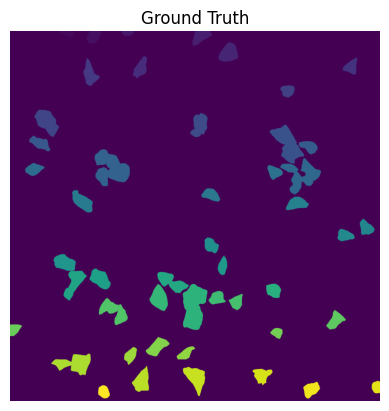

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from skimage.transform import resize


def dice_coefficient(y_true, y_pred):
    """Calcul du coefficient de Dice"""
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def IoU(y_true,y_pred):
    """Calcul du coefficient Intersection Over Union"""
    intersection=np.sum(y_true*y_pred)
    return (intersection/(np.sum(y_true)+np.sum(y_pred)-intersection)+1e-8)

#PATH_IMAGE='/Users/svelasco/Downloads/dataDorian/multi_focus/'
PATH_IMAGE='C:/Users/PILLLARD-DOR/Documents/TEMPO/data/multi_focus/'


PATH_SEGMENTATION=PATH_IMAGE+'/manual_annotations_independant/raw/'
#PATH_SEGMENTATION=PATH_IMAGE+'/SAM_segmentation/'
PATH_GT=PATH_IMAGE+'/ground_truth/'

image_name='Position_0003.png'

#Only one channel is necessary (Gray scale)
image=io.imread(PATH_IMAGE+'/focused_single_slice/contaminated/'+image_name)
print(image.shape)
#image=image[:,:,0]
plt.imshow(image,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

segmentation=io.imread(PATH_SEGMENTATION+image_name)
print(segmentation.shape)
#segmentation=segmentation[:,:,0]
plt.imshow(segmentation,cmap='gray')
plt.title('SAM Segmentation')
plt.axis('off')
plt.show()

ground_truth=io.imread(PATH_GT+image_name)
print(ground_truth.shape)
plt.imshow(ground_truth,cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

In [129]:

def binary_labeling(ground_truth):
    binary_segmentation = (ground_truth[:,:,0]==68) * (ground_truth[:,:,1]==1) * (ground_truth[:,:,2]==84)
    return 1-binary_segmentation

def binary_sam(sam):
    binary_sam = sam>0
    return binary_sam

def binary_independant(independant):
    binary_independant=independant>0
    return binary_independant

(2072, 2072, 4)


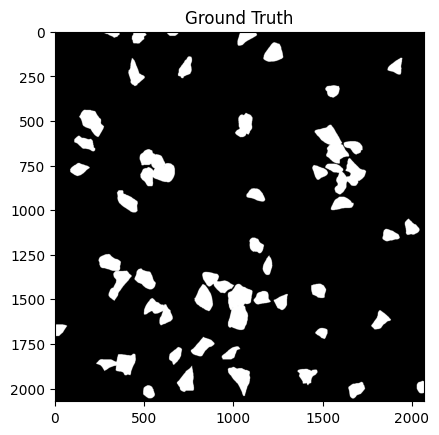

In [130]:
ground_truth=io.imread(PATH_GT+image_name)
print(ground_truth.shape)
plt.imshow(binary_labeling(ground_truth),cmap='gray')
plt.title('Ground Truth')
#plt.axis('off')
plt.show()

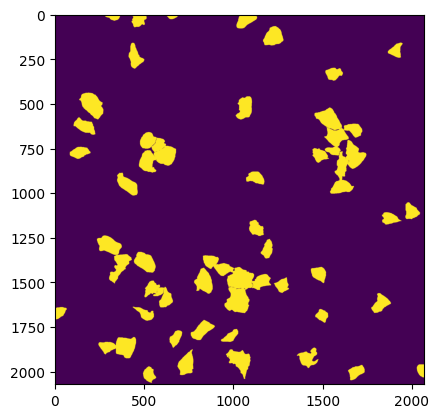

In [131]:
#plt.imshow(binary_sam(segmentation),cmap='gray')
#print(segmentation.shape)

plt.imshow(binary_independant(segmentation))

In [132]:
#print(binary_labeling(ground_truth).shape)
#print(resize(binary_sam(segmentation).shape)
dice_coefficient(binary_labeling(ground_truth), resize(binary_sam(segmentation),ground_truth.shape[:2],preserve_range=True))

np.float64(0.9209895674276378)

In [133]:
IoU(binary_labeling(ground_truth), resize(binary_sam(segmentation),ground_truth.shape[:2],preserve_range=True))

np.float64(0.8535502071301801)

In [134]:
print(ground_truth.shape)

(2072, 2072, 4)


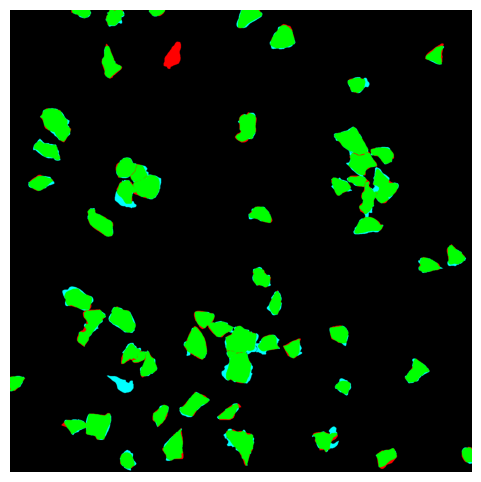

In [135]:
resized_SAM=resize(binary_sam(segmentation),ground_truth.shape[:2],preserve_range=True)
binary_ground_truth=binary_labeling(ground_truth)>0
difference=np.zeros((2072,2072,3),dtype=np.uint8)

#Vrais positifs
difference[binary_ground_truth & resized_SAM]=[0,255,0]

#Faux négatifs
difference[~resized_SAM & binary_ground_truth]=[255,0,0]

#Faux positifs
difference[resized_SAM & ~binary_ground_truth]=[0,255,255]

plt.figure(figsize=(6,6))
plt.imshow(difference)
plt.axis('off')
plt.show()

48
43


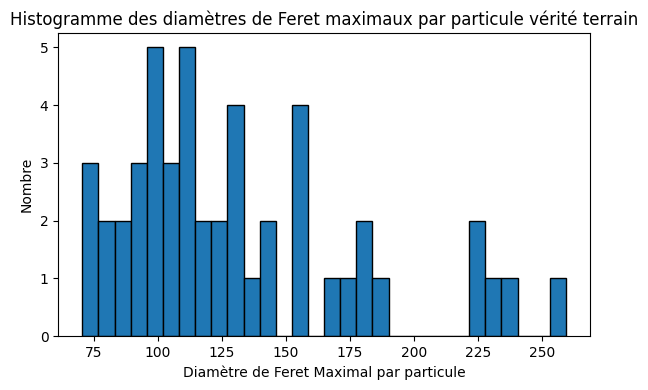

In [136]:
from skimage.measure import label, regionprops, regionprops_table

labeled_ground_truth=label(binary_labeling(ground_truth))
labeled_segmentation=label(binary_independant(segmentation))

ground_truth_regions=regionprops(labeled_ground_truth)
segmentation_regions=regionprops(labeled_segmentation)

print(len(ground_truth_regions))
print(len(segmentation_regions))

feret_values_GT=[region.feret_diameter_max for region in ground_truth_regions]
feret_values_seg=[region.feret_diameter_max for region in segmentation_regions]

plt.figure(figsize=(6,4))
plt.hist(feret_values_GT, bins=30, edgecolor='black')
plt.xlabel("Diamètre de Feret Maximal par particule")
plt.ylabel('Nombre')
plt.title('Histogramme des diamètres de Feret maximaux par particule vérité terrain')
plt.tight_layout()
plt.show()






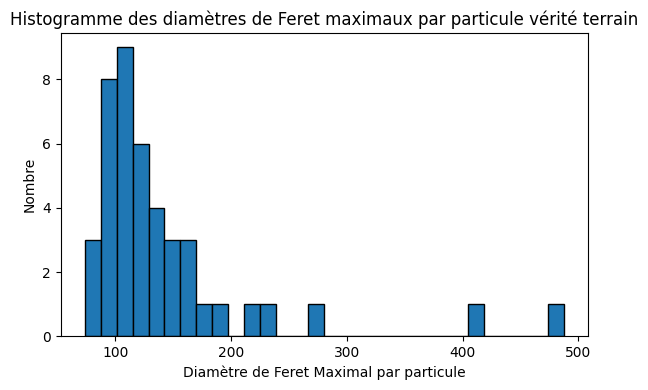

"\nliste d'arguments pour regionprops déjà existants:\n- equivalent diameter\n- min/max feret diameter\n- area\n- eccentricity\n\nliste d'arguments pour lesquels il faudrait créer la fonction pour calculer les grandeurs:\n- diamètre de martin\n- sphère équivalente\n- cercle inscrit\n- cercle cironscrit\n"

In [137]:
plt.figure(figsize=(6,4))
plt.hist(feret_values_seg, bins=30, edgecolor='black')
plt.xlabel("Diamètre de Feret Maximal par particule")
plt.ylabel('Nombre')
plt.title('Histogramme des diamètres de Feret maximaux par particule vérité terrain')
plt.tight_layout()
plt.show()


"""
liste d'arguments pour regionprops déjà existants:
- equivalent diameter
- min/max feret diameter
- area
- eccentricity

liste d'arguments pour lesquels il faudrait créer la fonction pour calculer les grandeurs:
- diamètre de martin
- sphère équivalente
- cercle inscrit
- cercle cironscrit
"""

In [138]:
from scipy.stats import wasserstein_distance

histogramme_GT, bins=np.histogram(feret_values_GT, bins=30, density=True)
histogramme_seg, _ =np.histogram(feret_values_seg, bins=30, density=True)

bin_centers=0.5*(bins[:-1]+bins[1:])

emd = wasserstein_distance(
    bin_centers,
    bin_centers,
    u_weights=histogramme_GT,
    v_weights=histogramme_seg
)

print(emd)

emd=wasserstein_distance(
    feret_values_GT,
    feret_values_seg
)

print(emd)

29.210447822962532
14.359581747246889
